# Developing a model for current sales price

There are only about 5,000 records for recent sales, but it's important that I not obfuscate the problem by mixing old and modern sales. For one thing the housing prices index will change, but it's not as simple as that either. Effectively, I'll be modeling what features determine a home's value. Those preferences change over time. For example a house built in 1960 is generally not particularly valuable today, but it would have been in 1960.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import join

# modeling imports
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler  # for standardization pipeline
from sklearn.pipeline import Pipeline


from scipy.stats import skew
from scipy.stats.stats import pearsonr

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
# read in the data

data = pd.read_pickle(join('../shared_data', 'recent_parc.pkl'))


In [3]:
data.head()

,dist_AUBURN,dist_BELLEVUE,dist_BLACK DIAMOND,dist_BOTHELL,dist_BURIEN,dist_CARNATION,dist_CLYDE HILL,dist_COVINGTON,dist_DES MOINES,dist_DUVALL,dist_ENUMCLAW,dist_FEDERAL WAY,dist_HUNTS POINT,dist_ISSAQUAH,dist_KENMORE,dist_KENT,dist_KING COUNTY,dist_KIRKLAND,dist_LAKE FOREST PARK,dist_MAPLE VALLEY,dist_MEDINA,dist_MERCER ISLAND,dist_NEWCASTLE,dist_NORMANDY PARK,dist_NORTH BEND,dist_PACIFIC,dist_REDMOND,dist_RENTON,dist_SAMMAMISH,dist_SEATTLE,dist_SHORELINE,dist_SNOQUALMIE,dist_SeaTac,dist_TUKWILA,dist_WOODINVILLE,dist_YARROW POINT,Topography,str_surf_1,str_surf_2,View_1,View_2,View_3,PowerLines,HistoricSite,no_stories,bath_count,bin_bedroom_count,year_renovated,year_built,ParcSqFtLot,SqFtTotLiving,sq_ft_upper_floor,landmark_prox_1,landmark_prox_2,park_prox_1,park_prox_2,light_rail_prox_1,light_rail_prox_2,pub_schl_prox_1,pub_schl_prox_2,priv_schl_prox_1,priv_schl_prox_2,lat,lon,appr_tot_val,appr_date,sale_date,sale_price
pin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4036100060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,5.0,2000,1966,9488,2530,0,0,1,0,1,0,0,0,0,0,0,47.562031,-122.183779,573000,2016-08-23,2016-05-16,710000
7893202650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,3.0,2000,1953,7500,1230,0,0,0,0,0,0,1,0,0,0,1,47.418384,-122.334462,244000,2016-09-07,2015-12-14,255000
3529300330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,2.0,2,3.0,2000,1991,6922,1980,0,0,0,0,0,0,0,0,0,0,0,47.396020,-122.183738,372000,2016-06-22,2013-06-22,206000
7304300215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,2.0,2000,1947,8184,980,0,0,7,0,29,0,0,0,17,0,17,47.742039,-122.322172,305000,2016-06-20,2015-10-23,319000
7660100130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,2.0,2000,1927,6000,760,0,2,309,2,170,0,9,0,42,0,38,47.590836,-122.316990,390000,2016-07-04,2016-04-14,200083


In [8]:
# Defining numeric and categorical features

# standardize all numeric features
# ideally, we want a mean of 0 and std dev of 1 for all numeric features
# for categorical features I'm going to use -1 for a negative response and 1 for a positive response
numeric_features = [
    'View_1', 'View_2', 'View_3',
    'no_stories', 'bath_count', 'bin_bedroom_count',
    'year_renovated', 'year_built', 'ParcSqFtLot', 'SqFtTotLiving',
    'sq_ft_upper_floor', 'lon', 'lat', 'light_rail_prox_1', 'light_rail_prox_2',
    'park_prox_1', 'park_prox_2', 'landmark_prox_1', 'landmark_prox_2',
    'pub_schl_prox_1', 'pub_schl_prox_2', 'priv_schl_prox_1',
    'priv_schl_prox_2'
]
categorical_features = [
    'dist_AUBURN', 'dist_BELLEVUE', 'dist_BLACK DIAMOND', 'dist_BOTHELL',
    'dist_BURIEN', 'dist_CARNATION', 'dist_CLYDE HILL', 'dist_COVINGTON',
    'dist_DES MOINES', 'dist_DUVALL', 'dist_ENUMCLAW', 'dist_FEDERAL WAY',
    'dist_HUNTS POINT', 'dist_ISSAQUAH', 'dist_KENMORE', 'dist_KENT',
    'dist_KING COUNTY', 'dist_KIRKLAND', 'dist_LAKE FOREST PARK',
    'dist_MAPLE VALLEY', 'dist_MEDINA', 'dist_MERCER ISLAND',
    'dist_NEWCASTLE', 'dist_NORMANDY PARK', 'dist_NORTH BEND',
    'dist_PACIFIC', 'dist_REDMOND', 'dist_RENTON', 'dist_SAMMAMISH',
    'dist_SEATTLE', 'dist_SHORELINE', 'dist_SNOQUALMIE', 'dist_SeaTac',
    'dist_TUKWILA', 'dist_WOODINVILLE', 'dist_YARROW POINT', 'Topography',
    'str_surf_1', 'str_surf_2', 'PowerLines',
    'HistoricSite'
]

def standardize_features(df, features):
    """Given list of categorical columns, standardize features to mean of 0 and stddev of 1"""   
    partial_df = df[features]
    partial_df = (partial_df - partial_df.mean()) / partial_df.std()
    df[features] = partial_df[features]
    return df

def standardize_array(array):
    return np.log1p((array - np.mean(array)) / np.std(array) + 1)


# df = standardize_features(data, categorical_features)
# df = standardize_features(df, numeric_features)

In [34]:
# train test split

def reset_data():
    global X, y, X_train, X_test, y_train, y_test
    y = data.sale_price
    X = data.drop(['appr_tot_val', 'appr_date', 'sale_date', 'sale_price'], axis=1)  # It would be cheating to use these
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [27]:
# Ridge

reset_data()

alphas = [1e-15, 1e-10, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.3, 1, 3, 4, 5, 6, 7, 8, 10]
ms_errors = []

for alpha in alphas:
    ridge_pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('ridge', Ridge(alpha))
    ])
    ridge_model = ridge_pipe.fit(X_train, standardize_array(y_train))
    y_pred = ridge_model.predict(X_test)
    mse = mean_squared_error(standardize_array(y_test), y_pred)
    ms_errors.append(mse)

def plot_results(parameter, mses, title):
    plt.plot(parameter, mses)
    plt.title(title)
    plt.xlabel('Alpha')
    plt.ylabel('MSE (lower is better)')
    min_error = min(mses)
    alph_idx = mses.index(min_error)
    best_alpha = parameter[alph_idx]
    print('Min. MSE={}, RMSE={} at {}'.format(min_error, np.sqrt(min_error), best_alpha))

Min. MSE=0.0540316065184696, RMSE=0.232446997224033 at 1e-15


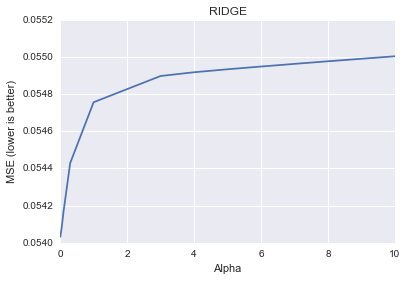

In [28]:
plot_results(alphas, ms_errors, 'RIDGE')

/Users/glpeterkin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/glpeterkin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Min. MSE 0.05461676813031647 at 0.0005


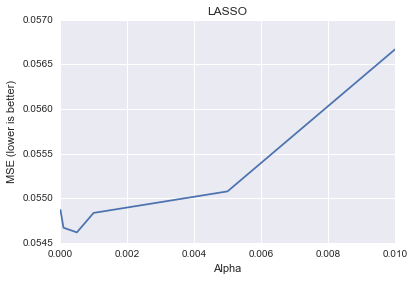

In [26]:
# lasso

reset_data()

alphas = [0.01, 0.005, 0.001, 0.0005, 1e-4, 1e-5]
ms_errors = []

for alpha in alphas:
    lasso_pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('lasso', Lasso(alpha=alpha))
    ])
    lasso_model = lasso_pipe.fit(X_train, standardize_array(y_train))
    y_pred = lasso_model.predict(X_test)
    mse = mean_squared_error(standardize_array(y_test), y_pred)
    ms_errors.append(mse)

plot_results(alphas, ms_errors, 'LASSO')

In [39]:
# random forests

reset_data()

# list of values to try for n_estimators
estimator_range = range(100, 500, 50)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg_pipe = Pipeline([
        ('standardize', StandardScaler()),
        ('rfreg', RandomForestRegressor(n_estimators=estimator, random_state=123, n_jobs=-1))
    ])
    MSE_scores = cross_val_score(rfreg_pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    print('.', end='')


........

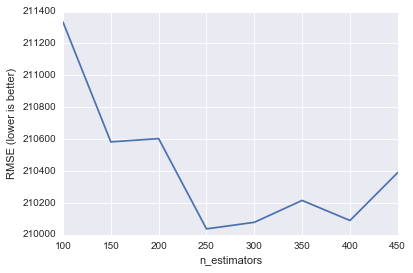

In [40]:
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

/Users/glpeterkin/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Picked 25 variables and eliminated 39


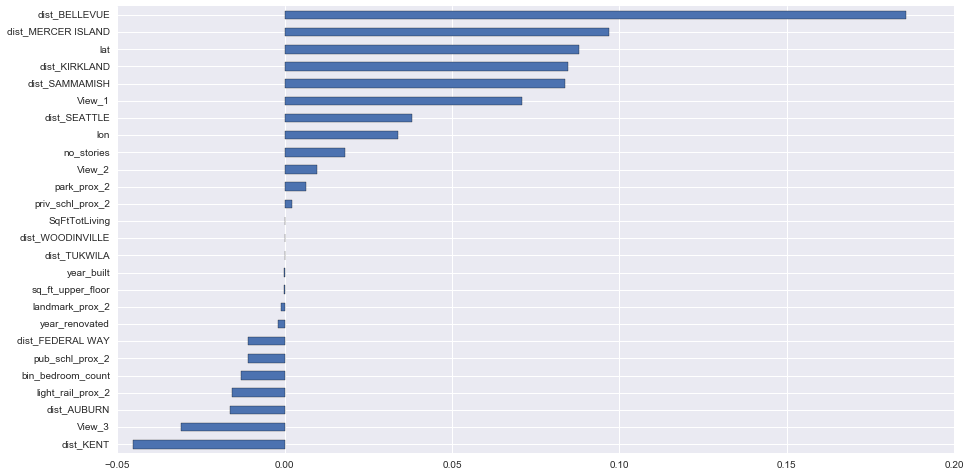

In [45]:
# so it beats the null but I have no idea how to interpret this

reset_data()

alpha=0.005

lasso_pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('lasso', Lasso(alpha=alpha))
])
model_lasso = Lasso(alpha=alpha).fit(X_train, standardize_array(y_train))

# NOTE: I'm significantly borrowing from
# https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
def view_coefficients(model_lasso, X_train=X_train):
    coef = pd.Series(model_lasso.coef_, index = X_train.columns)
    pick_count = str(sum(coef != 0))
    elim_count = str(sum(coef == 0))
    print('Picked {} variables and eliminated {}'.format(pick_count, elim_count))
    imp_coef = pd.concat([coef.sort_values().head(13), coef.sort_values().tail(13)])
    imp_coef.plot(kind = "barh", figsize=(15, 8))

view_coefficients(model_lasso)

In [41]:
# null mse
y_null = np.ones_like(standardize_array(y_test)) * np.mean(standardize_array(y_test))  # mean was better than median

print('null RMSE:', np.sqrt(mean_squared_error(standardize_array(y_test), y_null)))

null RMSE: 0.384415786271


In [46]:
# ridge_regression, lasso, randomforest

np.sqrt(0.05)

0.22360679774997896